In [10]:
import functools
import scipy.stats
import numpy as np
import pandas as pd
import mplfinance as mf
import matplotlib.pyplot as plt

P0, P1 = pd.Timestamp('2021-01-01'), pd.Timestamp('2021-07-18')

In [11]:
TWEET = pd.read_csv(
    'tweets.csv',
    dtype=str,
    squeeze=True,
    index_col='time',
    parse_dates=True,
    usecols=['time', 'text'],
    encoding='utf-8'
).rename('tweet')
TWEET = TWEET[TWEET.str.contains('doge', case=False)].iloc[::-1]
TWEET = TWEET[(TWEET.index > P0) & (TWEET.index <= P1)]
TWEET.index = TWEET.index.round('min')
EVENTS = TWEET.index
EVENTS

DatetimeIndex(['2021-02-04 07:36:00', '2021-02-04 08:15:00',
               '2021-02-04 08:27:00', '2021-02-07 22:25:00',
               '2021-02-10 15:08:00', '2021-02-11 09:09:00',
               '2021-02-14 23:25:00', '2021-02-21 21:27:00',
               '2021-03-01 19:57:00', '2021-03-06 04:40:00',
               '2021-03-13 23:41:00', '2021-03-13 23:46:00',
               '2021-03-13 23:51:00', '2021-04-01 10:25:00',
               '2021-04-15 04:33:00', '2021-04-28 06:21:00',
               '2021-05-11 08:14:00', '2021-05-13 22:45:00',
               '2021-05-20 10:41:00', '2021-05-24 19:50:00',
               '2021-05-24 20:30:00', '2021-07-01 08:44:00',
               '2021-07-01 09:24:00'],
              dtype='datetime64[ns]', name='time', freq=None)

In [12]:
dt = functools.partial(pd.to_datetime, unit='s')
DOGE = pd.read_csv(
    'DOGEUSDT.csv',
    sep='|',
    index_col='time',
    date_parser=dt,
    squeeze=True,
    usecols=['time', 'price'],
)
DOGE = DOGE[(DOGE.index > P0) & (DOGE.index <= P1)]
DOGE = DOGE.apply(lambda x: np.log(x+1))
DOGE.index = DOGE.index.round('min')
DOGE

time
2021-01-01 00:01:00    0.004669
2021-01-01 00:02:00    0.004665
2021-01-01 00:03:00    0.004665
2021-01-01 00:04:00    0.004665
2021-01-01 00:05:00    0.004661
                         ...   
2021-07-17 23:56:00    0.170308
2021-07-17 23:57:00    0.170257
2021-07-17 23:58:00    0.170662
2021-07-17 23:59:00    0.171716
2021-07-18 00:00:00    0.170949
Name: price, Length: 284517, dtype: float64

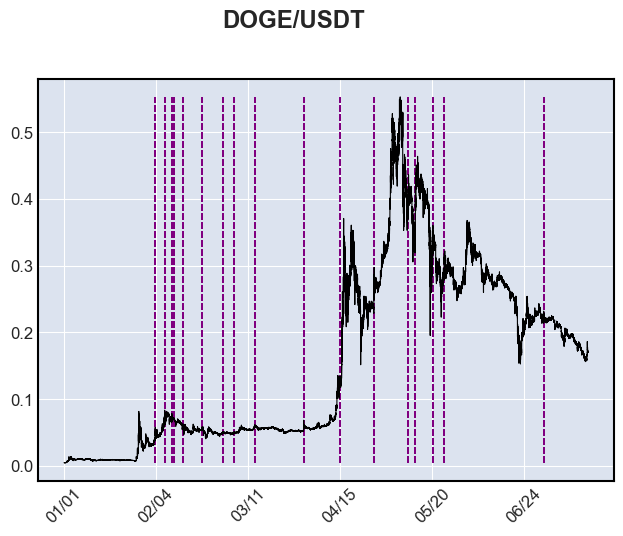

In [13]:
vlines = dict(vlines=list(EVENTS),
              colors='purple',
              linestyle='dashed',
              linewidths=1.25)
mf.plot(
    DOGE.to_frame(),
    type='line',
    vlines=vlines,
    title='DOGE/USDT',
    linecolor='black',
    columns=('price', ) * 5,
    ylabel=None,
    datetime_format='%m/%d',
)
plt.show()

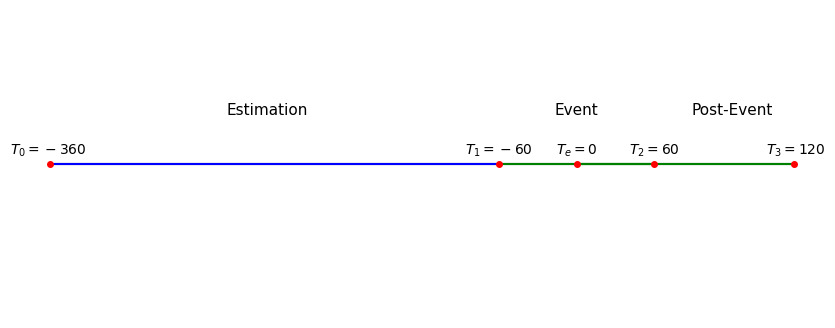

In [14]:
plt.style.use('default')

SIZE = 50
XMIN = 1
XMAX = SIZE - 1
Y = SIZE / 2
H = 1.5

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.set_xlim(0, SIZE)
ax.set_ylim(0, SIZE)

plt.hlines(Y, XMIN, XMAX, colors='black')
plt.hlines(Y, XMIN, 30, colors='blue', label='Estimation Window')
plt.hlines(Y, 35, XMAX, colors='green', label='Event Window')
plt.hlines(Y, 30, 40, colors='green', label='Event Window')
plt.plot(XMIN, Y, 'ro', ms=4, mfc='r')
plt.plot(XMAX, Y, 'ro', ms=4, mfc='r')
plt.plot(35, Y, 'ro', ms=4, mfc='r')
plt.text(35, Y + H, r'$T_{e} = 0$', horizontalalignment='center', fontsize=10)
plt.plot(40, Y, 'ro', ms=4, mfc='r')
plt.plot(30, Y, 'ro', ms=4, mfc='r')
plt.text(40, Y + H, '$T_{2} = 60$', horizontalalignment='center', fontsize=10)
plt.text(30, Y + H, '$T_{1} = -60$', horizontalalignment='center', fontsize=10)
plt.text(XMIN - 0.1,
         Y + H,
         '$T_{0} = -360$',
         horizontalalignment='center',
         fontsize=10)
plt.text(XMAX + 0.1,
         Y + H,
         '$T_{3} = 120$',
         horizontalalignment='center',
         fontsize=10)
plt.axis('off')
plt.annotate('Event', (35, 33), horizontalalignment='center', fontsize=11)
plt.annotate('Estimation', (15, 33), horizontalalignment='center', fontsize=11)
plt.annotate('Post-Event', (45, 33), horizontalalignment='center', fontsize=11)
plt.savefig('timeline.png', bbox_inches='tight')
plt.show()

In [15]:
Min = pd.offsets.Minute 

T0, T1, TE, T2, T3 = Min(-360), Min(-60), Min(0), Min(60), Min(120)

LABELS = [15, 30, 45, 60, 75, 90, 105, 120]
PERIODS = zip((EVENTS + T0), (EVENTS + T1), (EVENTS + TE), (EVENTS + T2), (EVENTS + T3))

data = dict()
for N, (W0, W1, WE, W2, W3) in enumerate(PERIODS):
    N += 1
    P = DOGE[W0:W3]
    # estimation window
    ET = DOGE[W0-Min(1):W1]
    # event window
    EV = DOGE[WE-Min(1):W3]
    # expected 
    ER = ET.pct_change().mean()
    # observed
    OR = EV.pct_change()  # .expanding().agg('mean')
    # abnormal
    AR = (OR - ER).rename('AR')
    CAR = AR.cumsum() .rename('CAR (%)')
    TST = (CAR / AR.expanding().std()).rename('t-stat')
  
    df = pd.concat([CAR * 100, TST], axis=1).dropna()
    df = df.reset_index(drop=True)
    df.index += 1
    df = df.loc[LABELS]
    df = df.rename_axis('Window')
    data[N] = df

df = pd.concat(data.values(), keys=data.keys(), names=['Event'])
df

CAR (%)     t-stat
Event Window                      
1     15      13.502827   4.225674
      30      35.396491  12.293345
      45      34.797078  11.846406
      60      28.458747  10.163546
      75      17.643901   6.439215
...                 ...        ...
23    60       0.593459   1.367582
      75       1.086593   2.731222
      90       1.171364   3.179981
      105      1.917251   5.458148
      120      2.723581   8.167453

[184 rows x 2 columns]

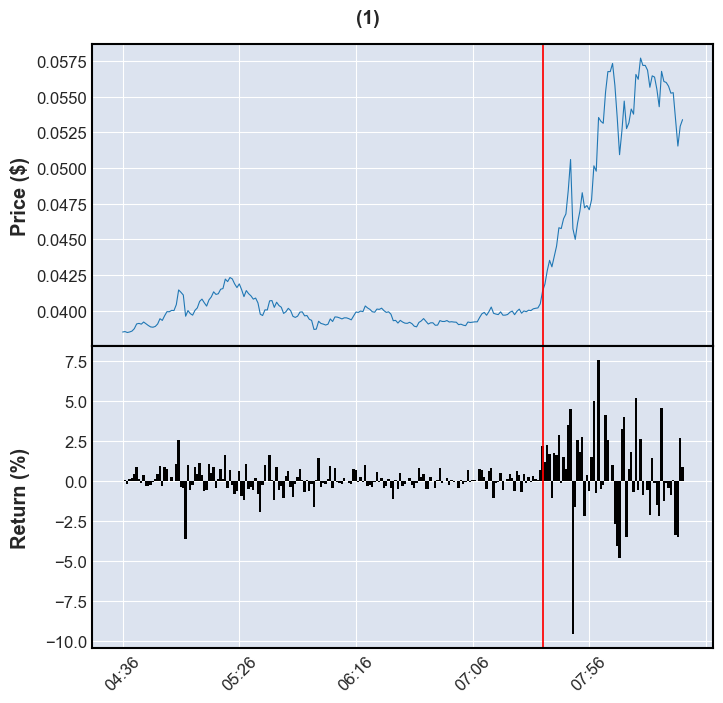

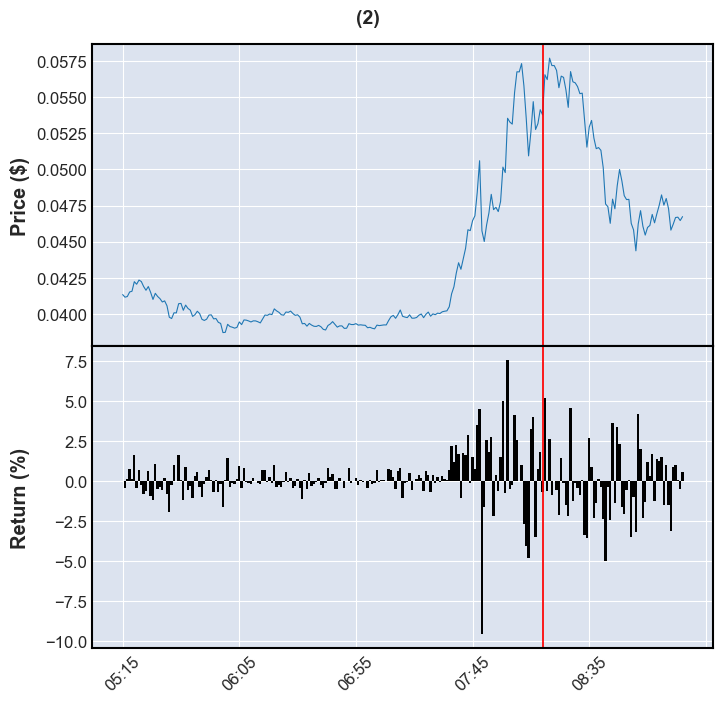

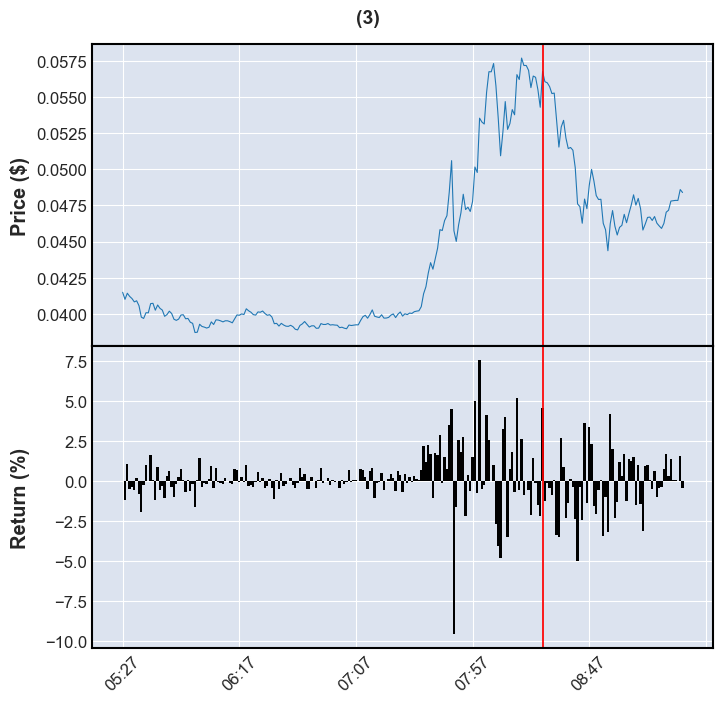

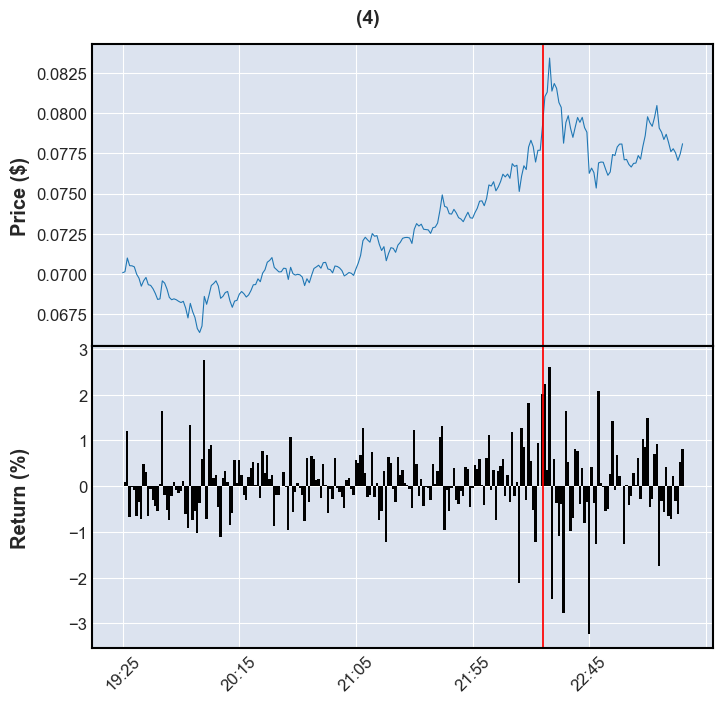

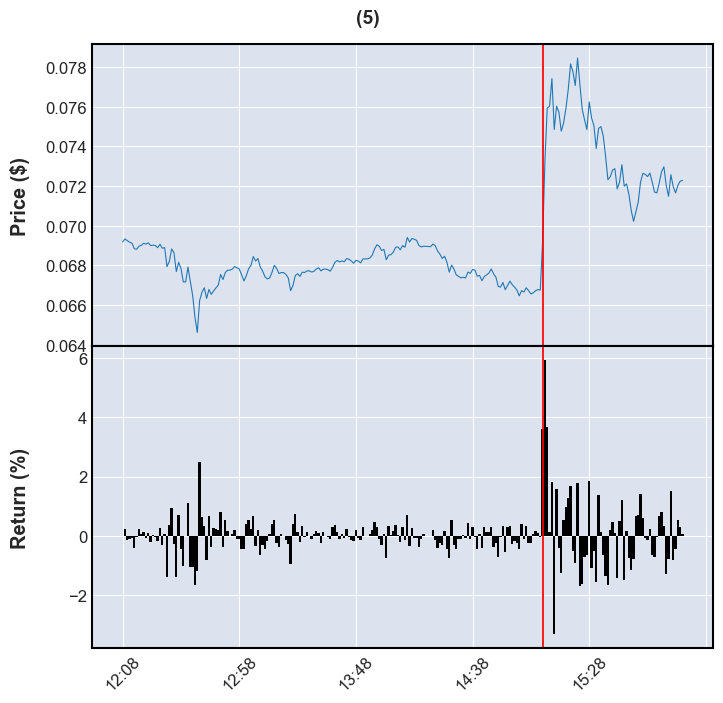

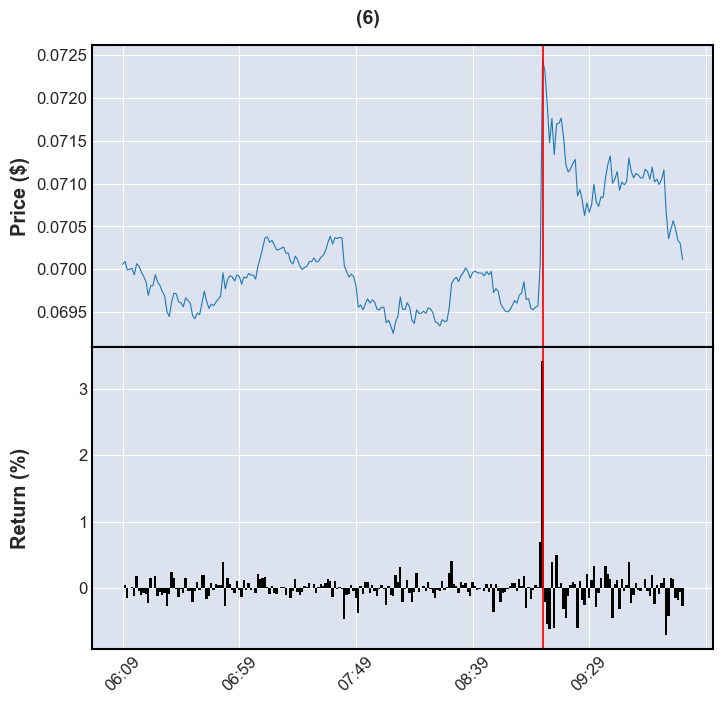

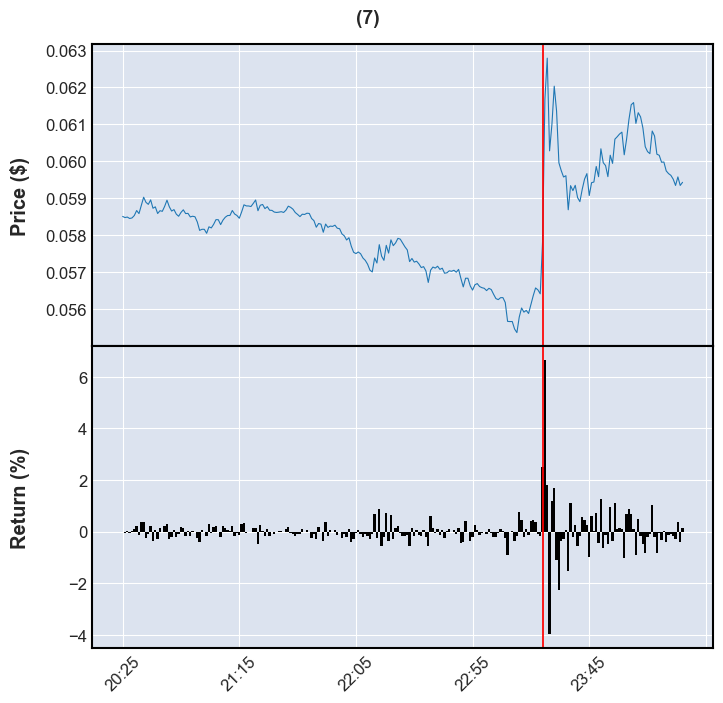

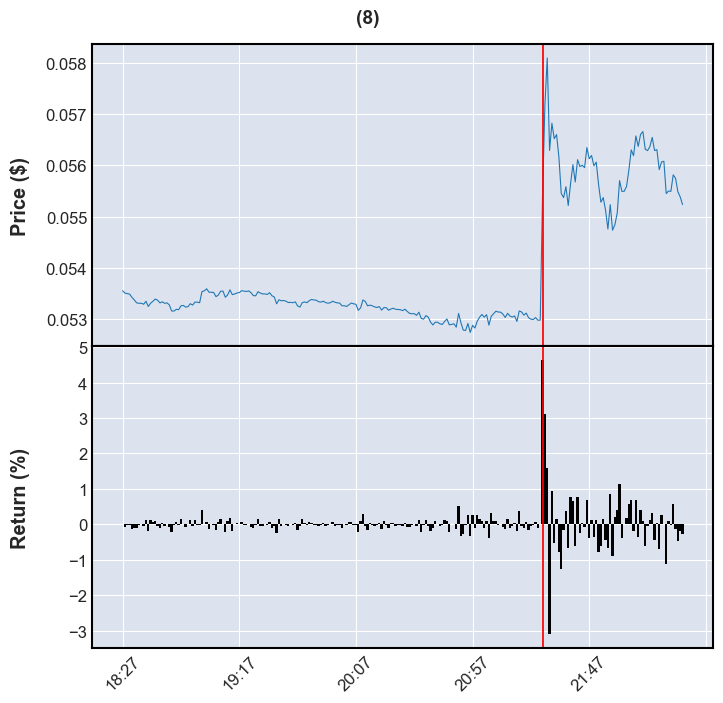

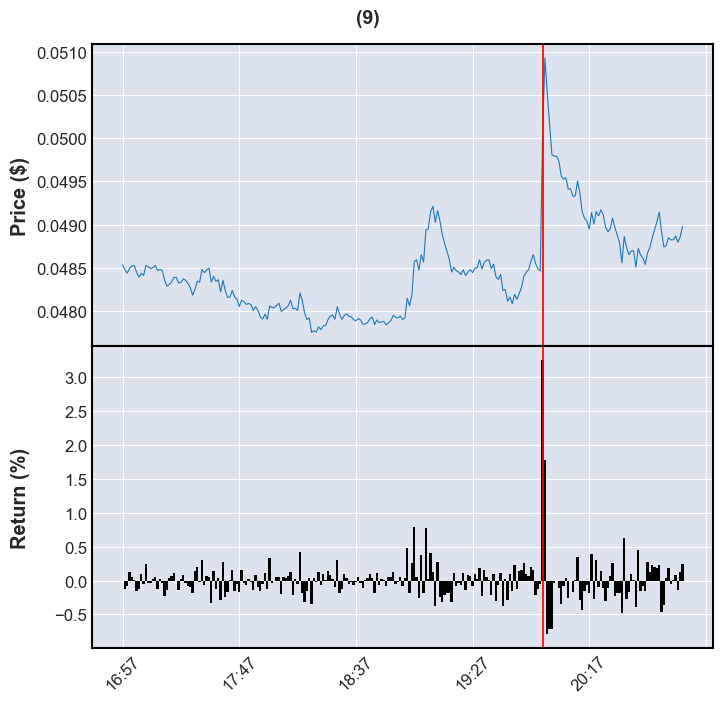

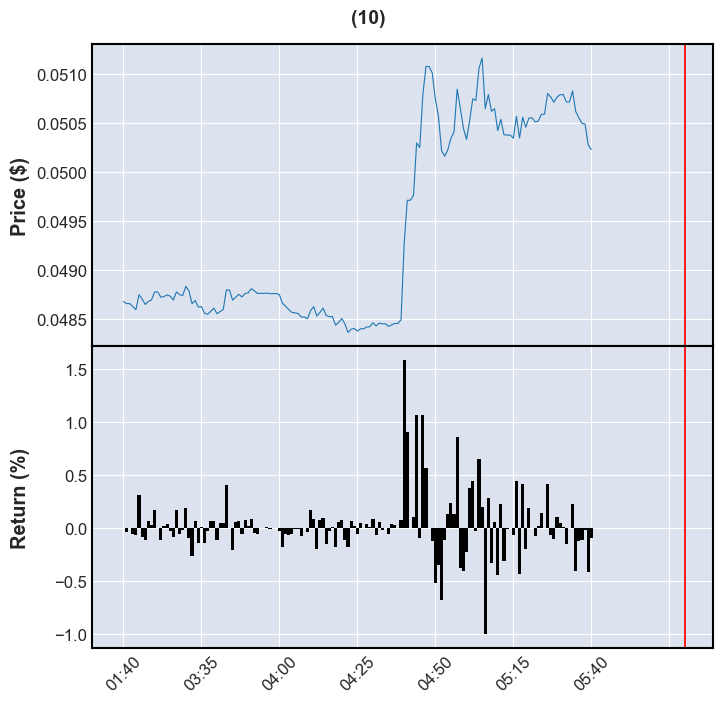

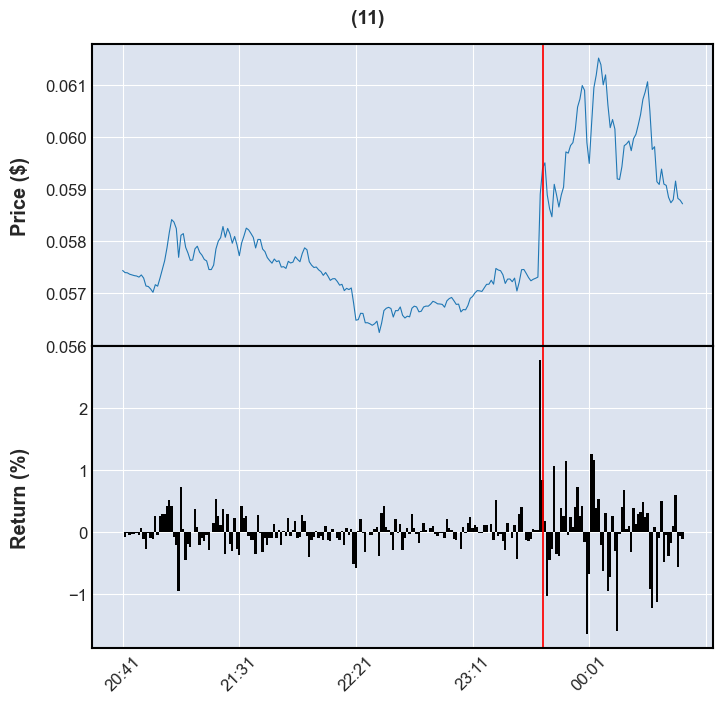

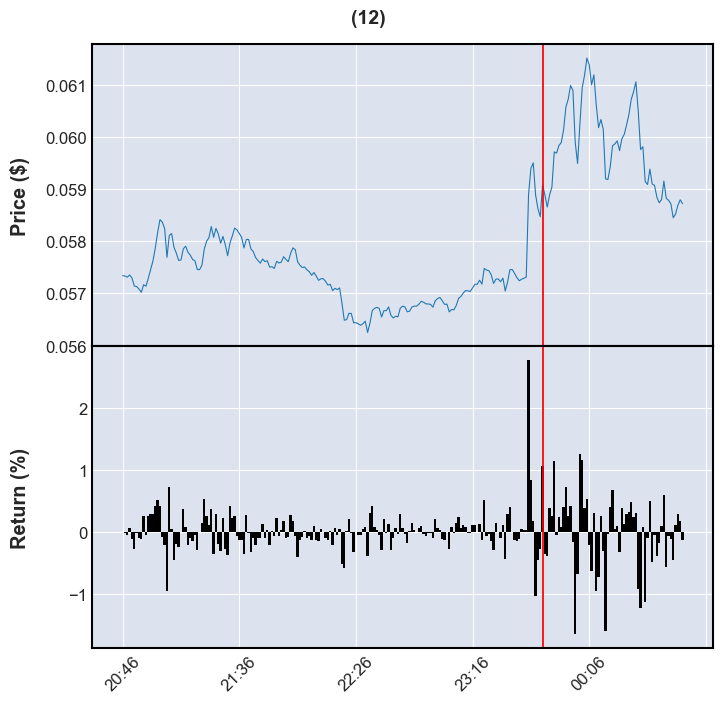

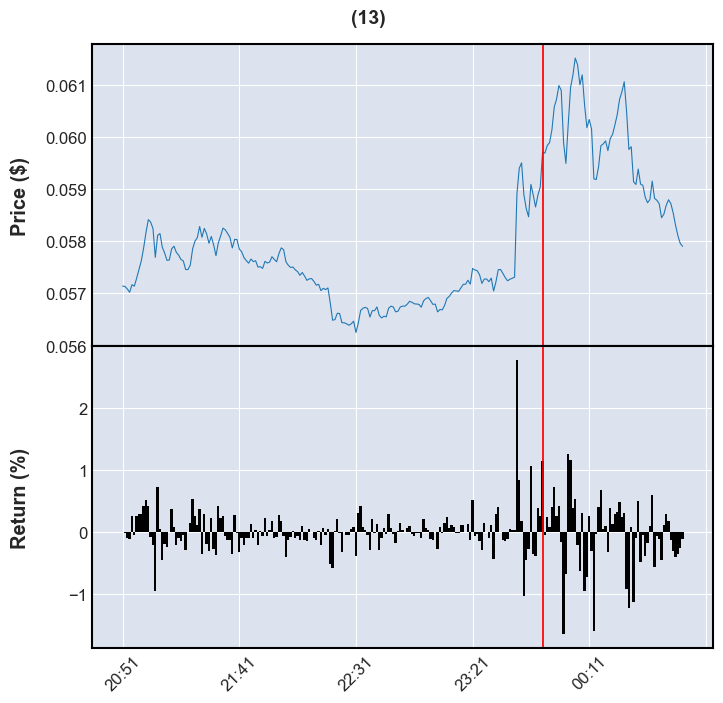

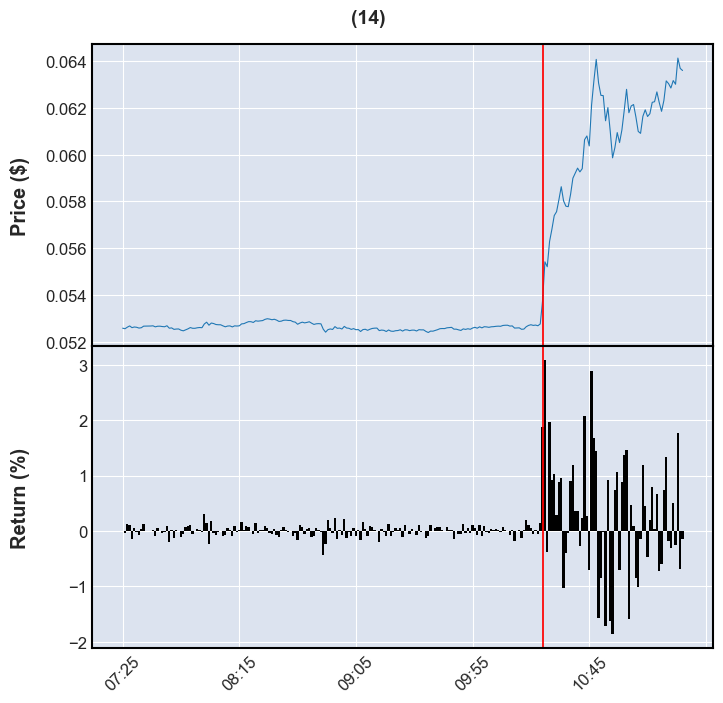

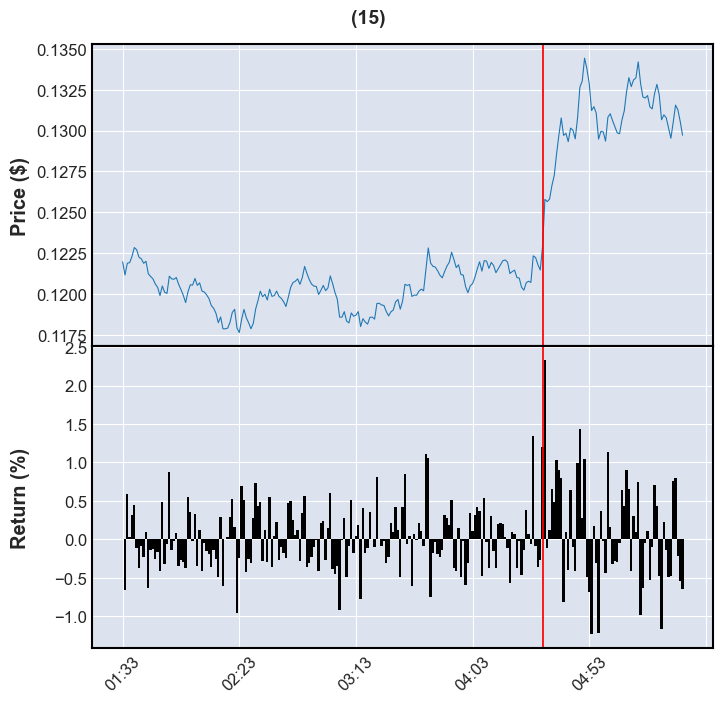

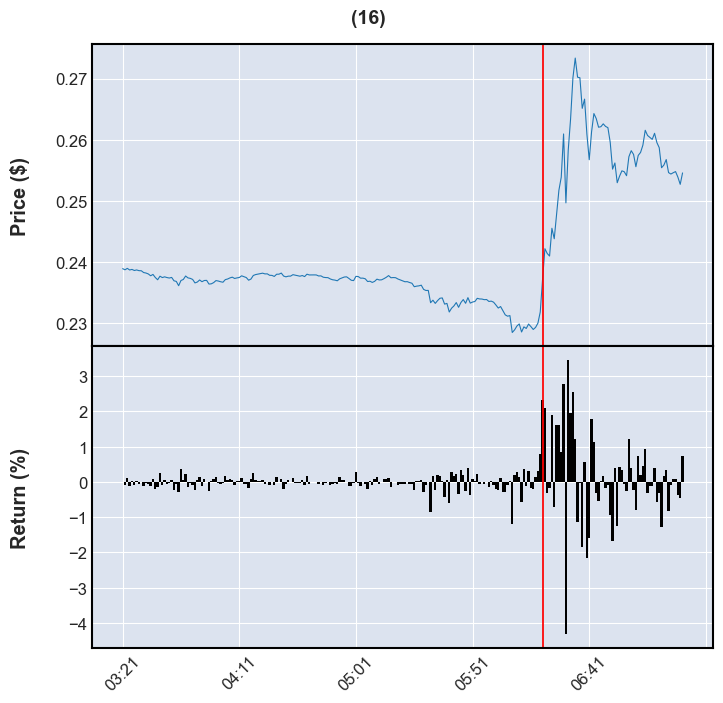

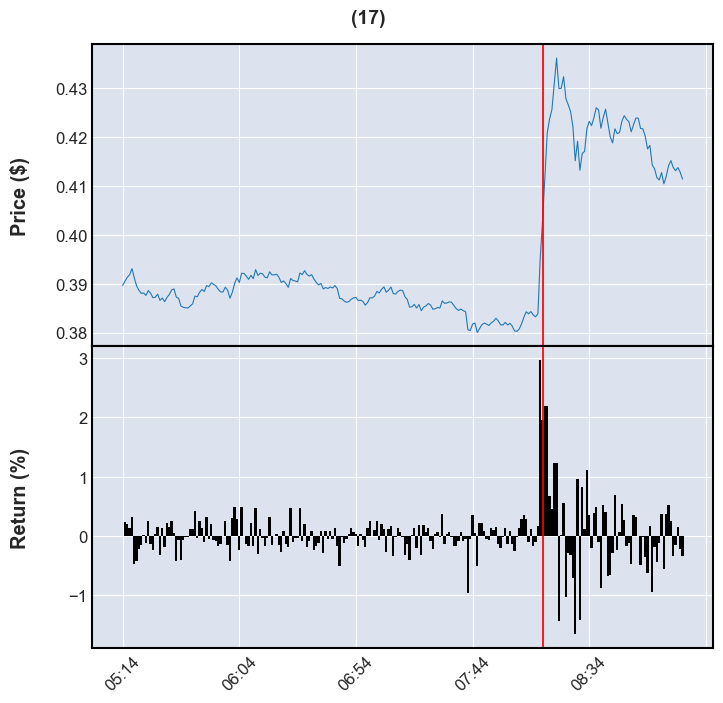

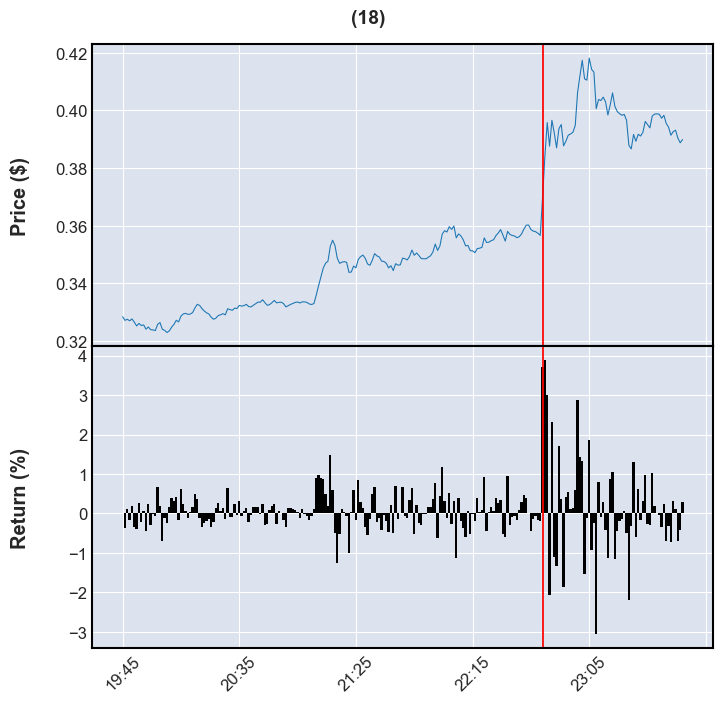

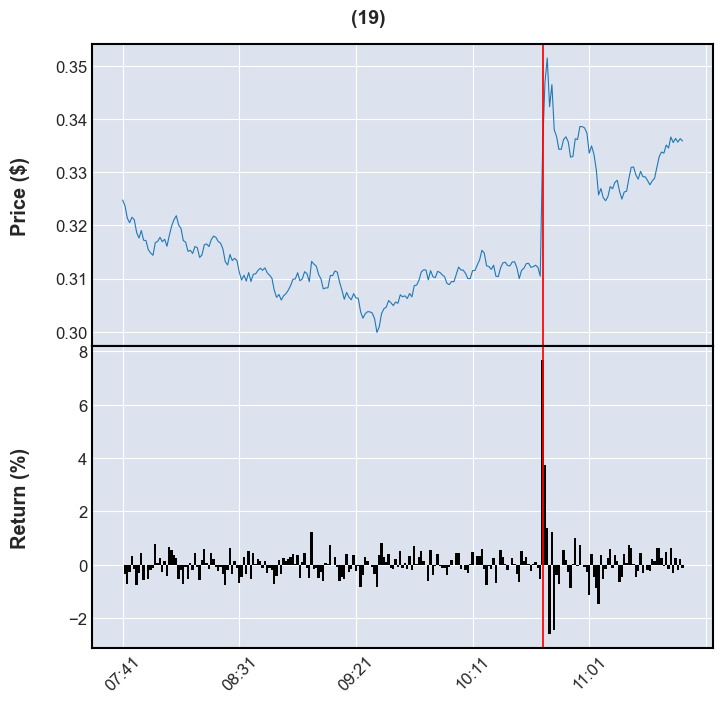

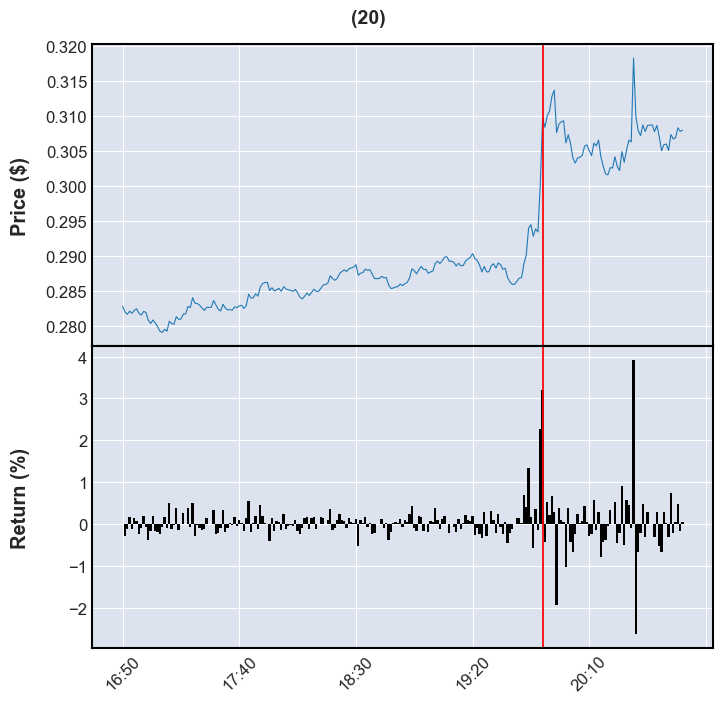

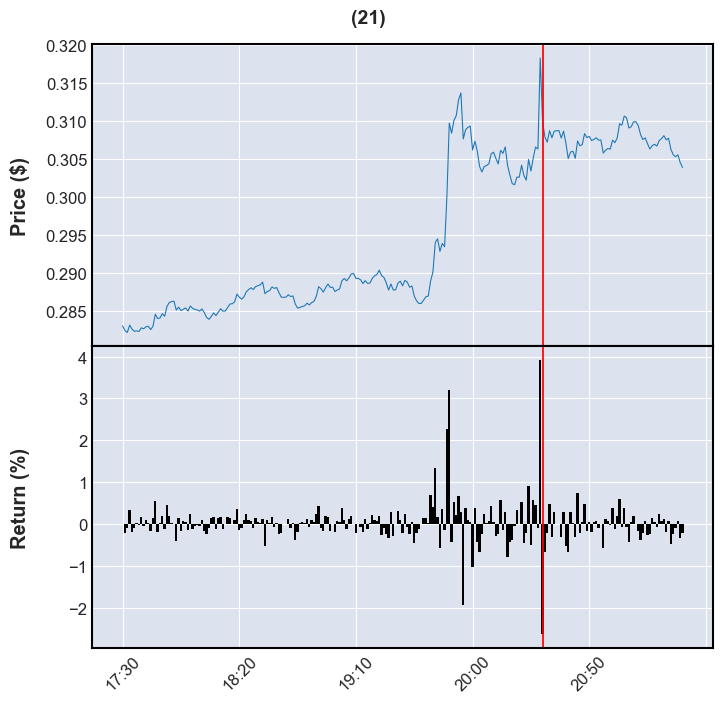

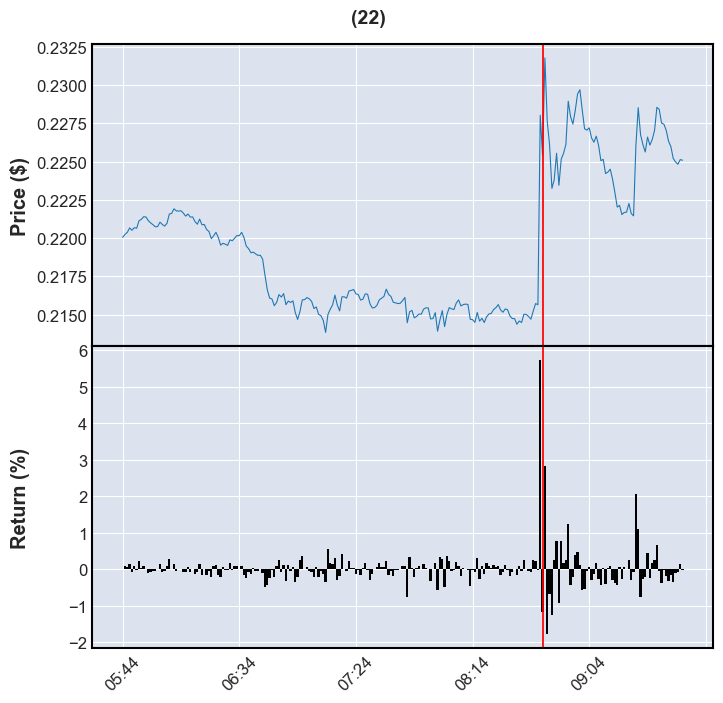

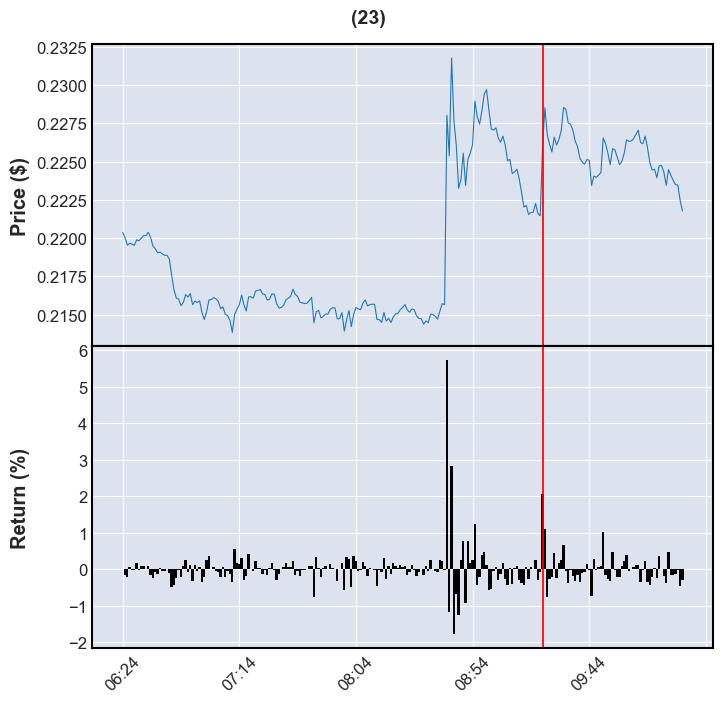

In [16]:
T0, T1 = Min(-180), Min(60)
WINDOWS = zip((EVENTS + T0), EVENTS, (EVENTS + T1))

for ESW, W, EVW in WINDOWS:
    T = TWEET[W]
    P = DOGE[ESW:EVW]
    # V = DOGE.volume[ESW:EVW]
    R = (P.pct_change() * 100)
    RP = mf.make_addplot(
        R,
        type='bar',
        panel=1,
        width=1,
        color='black',
        ylabel='Return (%)',
    )

    fig, axs = mf.plot(
        P.to_frame(),
        type='line',
        addplot=[RP],
        columns=('price', ) * 5,
        ylabel='Price ($)',
        figratio=(1, 1),
        figscale=1.5,
        panel_ratios=(1, 1),
        datetime_format='%H:%M',
        returnfig=True,
    )

    for ax in axs:
        ax.axvline(x=180, color='r', lw=1.25)
        ax.yaxis.set_label_coords(-0.1, 0.5)

    index = TWEET.index.get_loc(W) + 1
    fig.suptitle('(%d)' % index, y=0.90, fontsize=14, va='bottom')
    plt.show()
